# Introduction

This notebook has two audiences.

The first is new to mechanistic interpretability.

The second understands LLM interpretability, but has not yet applied these techniques to vision.

**Points to mention:**
* This notebook is heavily based on Exploratory Analysis, with some detours.
* Contributers // acknowledgements
* Link to the library

**Goals of this notebook**
* Basics of vision mech interp + equip people to do more advanced research
* Show ppl how to use library
* Encourage + inspire ppl for other projects in vision / multimodal mech interp

**Differences between ViT and LLM interpretability**
* Put differences here
* Bicausal attention
* CLS token gets fed in instead of next-token prediction (similar to EOS token)
* No canonical dictionary matrix; images have ambiguity
* Vision transformers have a gallery of losses; this uses classification / cross-entropy loss on the CLS token but other variants have masked loss, next-token loss, teacher-student loss, etc.

# Import libraries

In [1]:
%pip install git+https://github.com/soniajoseph/ViT-Prisma.git


  Cloning https://github.com/soniajoseph/ViT-Prisma.git to /tmp/pip-req-build-cfo30zdt
  Running command git clone --filter=blob:none --quiet https://github.com/soniajoseph/ViT-Prisma.git /tmp/pip-req-build-cfo30zdt
  Resolved https://github.com/soniajoseph/ViT-Prisma.git to commit f39502f2cabf4592f3f5dc97b6c254cd9ebbeb0c
  Preparing metadata (setup.py) ... done
  Created wheel for vit-prisma: filename=vit_prisma-0.1.1-py3-none-any.whl size=100627 sha256=a8eb0d68fa6ba479a4f0848d99e8c9fedd7b1e10a667347f6b52c1b5abcd4623
  Stored in directory: /tmp/pip-ephem-wheel-cache-i_94prku/wheels/04/99/f1/b15fc48756d7f8415320fb04edb8fdbe3f4e9f688c4b4a5504
Successfully built vit-prisma


In [2]:
%pip install fancy-einsum
%pip install jaxtyping
%pip install einops
%pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.3 MB/s eta 0:00:00


In [3]:
from vit_prisma.utils.data_utils.imagenet_dict import IMAGENET_DICT
import numpy as np
import torch
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px


In [4]:
# Get images we'll feed into the model

!wget https://github.com/soniajoseph/ViT-Prisma/blob/main/src/vit_prisma/sample_images/cat_dog.jpeg?raw=true -O cat_dog.jpeg
!wget https://github.com/soniajoseph/ViT-Prisma/blob/main/src/vit_prisma/sample_images/crop_dog.jpeg?raw=true -O crop_dog.jpeg

--2024-02-24 17:28:42--  https://github.com/soniajoseph/ViT-Prisma/blob/main/src/vit_prisma/sample_images/cat_dog.jpeg?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/soniajoseph/ViT-Prisma/raw/main/src/vit_prisma/sample_images/cat_dog.jpeg [following]
--2024-02-24 17:28:43--  https://github.com/soniajoseph/ViT-Prisma/raw/main/src/vit_prisma/sample_images/cat_dog.jpeg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/soniajoseph/ViT-Prisma/main/src/vit_prisma/sample_images/cat_dog.jpeg [following]
--2024-02-24 17:28:43--  https://raw.githubusercontent.com/soniajoseph/ViT-Prisma/main/src/vit_prisma/sample_images/cat_dog.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133,

# Load model and data

## ViT Architecture

Put description of architecture here

In [5]:
# We'll use a vanilla vision transformer
from vit_prisma.models.base_vit import HookedViT
model = HookedViT.from_pretrained("vit_base_patch32_224",
                                        center_writing_weights=True,
                                        center_unembed=True,
                                        fold_ln=True,
                                        refactor_factored_attn_matrices=True,
                                    )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

{'n_layers': 12, 'd_model': 768, 'd_head': 64, 'model_name': 'timm/vit_base_patch32_224.augreg_in21k_ft_in1k', 'n_heads': 12, 'd_mlp': 3072, 'activation_name': 'gelu', 'eps': 1e-06, 'original_architecture': 'vit_base_patch32_224', 'initializer_range': 0.02, 'n_channels': 3, 'patch_size': 32, 'image_size': 224, 'n_classes': 1000, 'n_params': 88224232, 'return_type': 'class_logits'}


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

LayerNorm folded.
Centered weights writing to residual stream
Loaded pretrained model vit_base_patch32_224 into HookedTransformer


## Load data

Explain ImageNet 1000 classes are dictionary. Explain that this can vary depending on the dataset you use (visual concepts are less canonical than language). Explain that there is more ambiguity. Could be a collie or a Border collie; may not matter within a few degrees of semantic space. The ambiguity of non-LLM data will be a theme that will repeatedly come up.

For the sake of simplicity, we'll use ImageNet's 1000-class dictionary for our visual concepts. Our images may not be from ImageNet however.



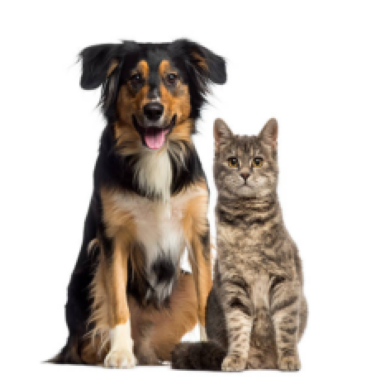

In [6]:
from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt


class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

# Define your transformations, including the custom ConvertTo3Channels
transform = transforms.Compose([
    ConvertTo3Channels(),  # Ensure all images are 3-channel without turning them grayscale
    transforms.Resize((224, 224)),  # Resize images to a common size.
    transforms.ToTensor(),  # Convert images to tensor.
    # You can include normalization if desired, using correct values for 3-channel images.
])

# Open and display the downloaded image
image = Image.open('cat_dog.jpeg')
image = transform(image)

plt.figure()
plt.axis('off')
plt.imshow(image.permute(1,2,0))


Mention disclaimer about just using one image for the sake of a demo; normally confirm circuit with several examples.

In [7]:
def display_grid_on_image(image, patch_size=32):

    if isinstance(image, torch.Tensor):
        image = image.detach().numpy().transpose(1,2,0)

    if image.shape[0] != 224:
        image = image.transpose(1,2,0)

    if image.max() <= 1.0:
        image = (image * 255).astype(np.uint8)

    num_patches = (image.shape[0] / patch_size) ** 2

    grid_size = int(np.sqrt(num_patches))

    # Calculate patch size
    patch_height = image.shape[0] // grid_size
    patch_width = image.shape[1] // grid_size

    # Overlay grida
    grid_image = np.copy(image)
    for i in range(1, grid_size):
        # Vertical lines
        grid_image[:, patch_width * i, :] = [255, 255, 255]
        # Horizontal lines
        grid_image[patch_height * i, :, :] = [255, 255, 255]

    plt.figure(figsize=(4, 4), dpi=100)  # Adjust figsize and dpi as needed

    # Place labels
    for i in range(grid_size):
        for j in range(grid_size):
            x_center = (j * patch_width) + (patch_width // 2)
            y_center = (i * patch_height) + (patch_height // 2)
            # Convert the patch index to 2D coordinates (row, column)
            patch_index = i * grid_size + j
            row, col = divmod(patch_index, grid_size)
            plt.text(x_center, y_center, f"{patch_index+1}", color='red', fontsize=8, ha='center', va='center')

    # Display image with grid and labels
    # plt.figure(figsize=(8, 8))
    plt.imshow(grid_image)
    plt.axis('off')
    plt.show()

    # return figure
    # return grid_image

Explain patches and the CLS token

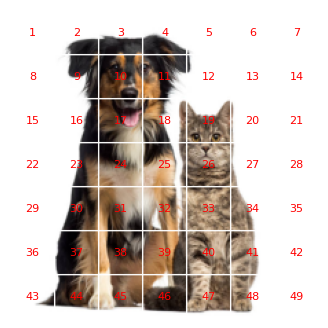

In [8]:
# [INSERT]
# Display with grid over it
display_grid_on_image(image)

## Test prompt

In [9]:
def test_prompt(example_prompt, model, example_answer=None, top_k=10):

    logits = model(example_prompt.unsqueeze(0))
    probs = logits.softmax(dim=-1)
    probs = probs.squeeze(0).detach().numpy()
    sorted_probs = np.sort(probs)[::-1]
    sorted_probs_args = np.argsort(probs)[::-1]

    for i in range(top_k):
        index = sorted_probs_args[i]
        prob = sorted_probs[i]
        logit = logits[0, index].item()  # Assuming you want to show the original logit value
        label = IMAGENET_DICT[index]  # Adjust based on your mapping

        rank_str = f"Top {i}th token."
        logit_str = f"Logit: {logit:.2f}"
        prob_str = f"Prob: {prob * 100:.2f}%"
        token_str = f"Label: |{label}|"

        print(f"{rank_str} {logit_str} {prob_str} {token_str}")


    if example_answer:
      tabby_cat_idx = imagenet_index_from_word(example_answer)

    # Example for displaying ranks of the answer tokens, adjust according to your needs
      answer_index = imagenet_index_from_word(example_answer)
      answer_indices = [answer_index]  # Assuming index is the answer index, adjust as necessary
      print("Rank of the correct answer:")
      for ans_index in answer_indices:
          rank = np.where(sorted_probs_args == ans_index)[0][0]
          print(f"Class Name: {example_answer} | Rank: {rank} | ImageNet Index: {tabby_cat_idx}")

def imagenet_index_from_word(search_term):
    # Convert the search term to lowercase to ensure case-insensitive matching
    search_term = search_term.lower()

    # Iterate over the dictionary and search for the term
    for key, value in IMAGENET_DICT.items():
        if search_term in value.lower():  # Convert each value to lowercase for case-insensitive comparison
            return key  # Return the key directly once found

    # If the loop completes without returning, the term was not found; raise an exception
    raise ValueError(f"'{search_term}' not found in IMAGENET_DICT.")


In [10]:
test_prompt(image, model)

Top 0th token. Logit: 8.68 Prob: 34.80% Label: |tabby, tabby cat|
Top 1th token. Logit: 7.59 Prob: 11.67% Label: |Bernese mountain dog|
Top 2th token. Logit: 7.12 Prob: 7.31% Label: |Border collie|
Top 3th token. Logit: 7.07 Prob: 6.96% Label: |Egyptian cat|
Top 4th token. Logit: 6.80 Prob: 5.32% Label: |collie|
Top 5th token. Logit: 6.63 Prob: 4.48% Label: |tiger cat|
Top 6th token. Logit: 6.43 Prob: 3.68% Label: |EntleBucher|
Top 7th token. Logit: 6.34 Prob: 3.35% Label: |Appenzeller|
Top 8th token. Logit: 4.93 Prob: 0.82% Label: |golden retriever|
Top 9th token. Logit: 4.90 Prob: 0.79% Label: |lynx, catamount|


We can see that the net predicts tabby and Bernese mountain dog as the two most probable classes! This is close-to-accurate! The other candidates are various other dogs and cats.

I am curious why the net decides the overall image is a tabby instead of a dog when both are present.

In [11]:
# Run Cache
logits, cache = model.run_with_cache(image.unsqueeze(0))

# Logit Attribution

I'm curious about tabby / dog values in relation to their predicted value throughout the net.

We can do direct logit attribution to see where in the net this computation is happening  and also how the net decides its final class.

## Layer attribution

In [12]:
def imagenet_index_from_word(search_term):
    # Convert the search term to lowercase to ensure case-insensitive matching
    search_term = search_term.lower()

    # Iterate over the dictionary and search for the term
    for key, value in IMAGENET_DICT.items():
        if search_term in value.lower():  # Convert each value to lowercase for case-insensitive comparison
            return key  # Return the key directly once found

    # If the loop completes without returning, the term was not found; raise an exception
    raise ValueError(f"'{search_term}' not found in IMAGENET_DICT.")

In [13]:
## Accumulated residual
cat_index = imagenet_index_from_word("tabby")
dog_index = imagenet_index_from_word("border collie")

print("Tabby index:", cat_index)
print("Border collie index: ", dog_index)

Tabby index: 281
Border collie index:  232


In [14]:
cat_answer_residual_direction = model.tokens_to_residual_directions(cat_index)
print(cat_answer_residual_direction.shape)

dog_answer_residual_direction = model.tokens_to_residual_directions(dog_index)
print(dog_answer_residual_direction.shape)

torch.Size([768])
torch.Size([768])


In [15]:

# Confirm manually
final_residual_stream = cache["resid_post", -1]

# Put 0 to get CLS token at beginning
cls_token_residual_stream = final_residual_stream[:, 0, :]

scaled_final_token_residual_stream = cache.apply_ln_to_stack(cls_token_residual_stream, layer=-1, pos_slice=0 )

cat_logit = einsum(
    "batch d_model, d_model -> batch",
    scaled_final_token_residual_stream,
    cat_answer_residual_direction,
)

dog_logit = einsum(
    "batch d_model, d_model -> batch",
    scaled_final_token_residual_stream,
    dog_answer_residual_direction,
)

cat_logit = cat_logit + model.head.b_H[cat_index]

print("Calculated tabby cat logit value:", round(cat_logit.item(), 3))
print("Tabby cat logit value taken directly from model's output logits:", round(logits[:,cat_index].item(),3))
print()
# print("Calculated average logit diff:", round(average_logit.item(), 3))
# print("Original logit difference:", round(average_answer.item(), 3))

dog_logit = dog_logit + model.head.b_H[dog_index]
print("Calculated Border collie logit value:", round(dog_logit.item(), 3))
print("Border collie logit value taken directly from model's output logits:", round(logits[:,dog_index].item(), 3))

Calculated tabby cat logit value: 8.681
Tabby cat logit value taken directly from model's output logits: 8.681

Calculated Border collie logit value: 7.121
Border collie logit value taken directly from model's output logits: 7.121


In [16]:
def average_logit_value_across_all_classes(
    residual_stack,
    cache
):
    scaled_residual_stack = cache.apply_ln_to_stack(
            residual_stack, layer=-1, pos_slice=0
        )

    all_residual_directions = model.tokens_to_residual_directions(np.arange(1000))

    logit_predictions = einsum(
        "layer batch d_model, batch d_model -> batch layer",
        scaled_residual_stack,
        all_residual_directions,
    )
    logit_predictions = logit_predictions.mean(axis=0)
    return logit_predictions



In [17]:
misc_index = imagenet_index_from_word("banana")
print("Banana index:", misc_index)
misc_residual_direction = model.tokens_to_residual_directions(misc_index)

Banana index: 954


In [18]:
import plotly.graph_objects as go

def residual_stack_to_logit(
    residual_stack,
    cache,
    answer_residual_directions
):

    scaled_residual_stack = cache.apply_ln_to_stack(
            residual_stack, layer=-1, pos_slice=0
        )

    print(residual_stack.shape)
    print(answer_residual_directions.shape)

    logit_predictions = einsum(
        "layer batch d_model, d_model -> layer",
        scaled_residual_stack,
        answer_residual_directions,
    )
    return logit_predictions


accumulated_residual, layer_labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, pos_slice=0, return_labels=True

    )

# Initialize figure outside the loop
fig = go.Figure()

# Prepare data and labels for iteration
residual_directions = [
    (cat_answer_residual_direction, 'Tabby Cat Logit', model.head.b_H[cat_index]),
    (dog_answer_residual_direction, 'Border Collie Logit', model.head.b_H[dog_index]),
    (misc_residual_direction, 'Banana Logit', model.head.b_H[misc_index]),
]



# Process each residual direction
for direction, label, bias in residual_directions:
    logit_predictions = residual_stack_to_logit(accumulated_residual, cache, direction)
    logit_predictions = logit_predictions.T + bias  # Add bias
    logit_predictions = logit_predictions.detach().numpy()
    hover_text = [f"{layer_labels[idx]}" for idx, diff in enumerate(accumulated_residual)]
    fig.add_trace(go.Scatter(y=logit_predictions, mode='lines', name=label, text=hover_text))

# Handle "Average Logit Across All Classes" separately if needed
average_total_logits = average_logit_value_across_all_classes(accumulated_residual, cache).detach().numpy()
fig.add_trace(go.Scatter(y=average_total_logits, mode='lines', name='Average Logit Across All Classes'))

# Update layout with appropriate titles
fig.update_layout(
    title="Logit through Model Layers",
    xaxis_title="Model Layer",
    yaxis_title="Logit Value",
)

# Show the plot
fig.show()
#

torch.Size([25, 1, 768])
torch.Size([768])
torch.Size([25, 1, 768])
torch.Size([768])
torch.Size([25, 1, 768])
torch.Size([768])


<ipython-input-18-b081fae44068>:44: UserWarning:

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)



In [19]:
import plotly.graph_objects as go

# Assuming `cache`, `average_logit_value_across_all_classes`, `residual_stack_to_logit`, and other necessary functions and variables are defined elsewhere

# Retrieve the per-layer residual and labels
per_layer_residual, layer_labels = cache.decompose_resid(
    layer=-1, pos_slice=0, return_labels=True
)

# Initialize the figure
fig = go.Figure()

# Iterate over each residual direction and its corresponding label
for direction, label, bias in residual_directions:
    per_layer_logit_diffs = residual_stack_to_logit(per_layer_residual, cache, direction)
    per_layer_logit_diffs = per_layer_logit_diffs.detach().numpy()  # Assuming you want the first element for some reason; adjust if necessary

    # Add a new trace for each set of logit differences
    hover_text = [f"{layer_labels[idx]}" for idx, diff in enumerate(per_layer_logit_diffs)]
    fig.add_trace(go.Scatter(y=per_layer_logit_diffs, mode='lines', name=label, text=hover_text))

# Handle average logits across all classes
average_total_logits = average_logit_value_across_all_classes(per_layer_residual, cache).detach().numpy()
fig.add_trace(go.Scatter(y=average_total_logits, name="Average Logit Across All Labels"))

# Update layout with appropriate titles
fig.update_layout(
    title="Logit through Model Layers",
    xaxis_title="Layer",
    yaxis_title="Logit Difference",
)

# Display the plot
fig.show()


torch.Size([26, 1, 768])
torch.Size([768])
torch.Size([26, 1, 768])
torch.Size([768])
torch.Size([26, 1, 768])
torch.Size([768])


## Patch-level logit lens

Put motivation for patches here.

Open question is how information moves between patches. Mention notebook tokens and registers.

We'll soon see that each patch encodes information locally and that we can use patches as a segmentation map.

In [20]:

def get_patch_logit_directions(cache):
    accumulated_residual, labels = cache.accumulated_resid(
        layer=-1, incl_mid=True, return_labels=True
    )
    scaled_residual_stack = cache.apply_ln_to_stack(
        accumulated_residual, layer=-1,
    )
    all_answers = model.tokens_to_residual_directions(np.arange(1000))

    result = torch.einsum('lbpd,od -> lbpo', scaled_residual_stack, all_answers)
    # Rearrange so batches are first
    result = result.permute(1, 2, 0, 3)
    return result

def get_patch_logit_dictionary(patch_logit_directions, batch_idx=0, rank_label=None):
    patch_dictionary = defaultdict(list)
    # Go through laeyrs of one batch
    for patch_idx, patches in enumerate(patch_logit_directions[batch_idx]):
        # Go through every patch and get max prediction
        for logits in patches:
            probs = torch.softmax(logits, dim=-1)
            # Get index of max prediction
            predicted_idx = int(torch.argmax(probs))
            logit = logits[predicted_idx].item()
            predicted_class_name = IMAGENET_DICT[predicted_idx]
            if rank_label:
                # Where is the rank_label in the sorted list?
                rank_index = imagenet_index_from_word(rank_label)
                sorted_list = torch.argsort(probs, descending=True)
                rank = np.where(sorted_list == rank_index)[0][0]
                patch_dictionary[patch_idx].append((logit, predicted_class_name, predicted_idx, rank))
            else:
                patch_dictionary[patch_idx].append((logit, predicted_class_name, predicted_idx))
    return patch_dictionary


In [21]:
patch_logit_directions = get_patch_logit_directions(cache)
patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, rank_label='tabby')
tabby_rank_formatted = np.array([[item[-1] for item in list(patch_dictionary.values())[i]] for i in range(50)])

patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, rank_label='collie')
collie_rank_formatted = np.array([[item[-1] for item in list(patch_dictionary.values())[i]] for i in range(50)])

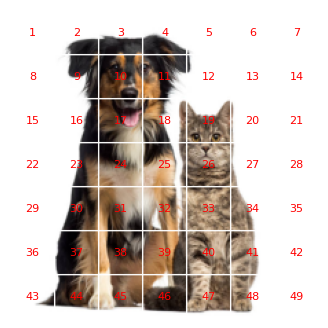

In [22]:
import plotly.graph_objects as go
import numpy as np

# Assuming get_patch_logit_directions and get_patch_logit_dictionary are defined elsewhere

# Initialize traces list for plotly
traces = []

# Define colors with darker shades
colors = {
    'tabby_cls': 'rgba(0, 0, 255, 1.0)',  # Blue
    'collie_cls': 'rgba(255, 0, 0, 1.0)',  # Red
    'tabby_patch': 'rgba(169, 169, 169, 0.5)',  # Darker Light Gray
    'collie_patch': 'rgba(218, 165, 32, 0.5)',  # Darker Light Golden
}

# Process Tabby traces
for i, patch_data in enumerate(tabby_rank_formatted):
    color = colors['tabby_cls'] if i == 0 else colors['tabby_patch']
    width = 2 if i == 0 else 1
    trace = go.Scatter(
        x = np.arange(25),
        y=patch_data,
        mode='lines+markers' if i == 0 else 'lines',
        line=dict(color=color, width=width),
        hoverinfo='text',
        text=[f'Layer {x + 1}, Patch {i} - Tabby, Rank: {y}' for x, y in enumerate(patch_data)],
        name='Tabby Rank for CLS' if i == 0 else 'Tabby Rank',
        showlegend=i < 2  # Show legend only for the first CLS and patch
    )
    traces.append(trace)

# Process Border Collie traces
for i, patch_data in enumerate(collie_rank_formatted):
    color = colors['collie_cls'] if i == 0 else colors['collie_patch']
    width = 2 if i == 0 else 1
    trace = go.Scatter(
        x = np.arange(25),
        y=patch_data,
        mode='lines+markers' if i == 0 else 'lines',
        line=dict(color=color, width=width),
        hoverinfo='text',
        text=[f'Layer {x + 1}, Patch {i} - Border Collie, Rank: {y}' for x, y in enumerate(patch_data)],
        name='Border Collie Rank for CLS' if i == 0 else 'Border Collie Rank',
        showlegend=i < 2  # Show legend only for the first CLS and patch
    )
    traces.append(trace)

fig = go.Figure(traces)

# Update plot layout to show the legend
fig.update_layout(
    title='Patch Ranks Over Layers for Tabby and Border Collie',
    xaxis_title='Layer',
    yaxis_title='Rank',
    hovermode='closest',
    legend_title='Legend',
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01
    )
)

fig.show()

display_grid_on_image(image.clone())

In [23]:
# Graph CLS rank and logit together

import plotly.graph_objects as go
from plotly.subplots import make_subplots

cls_token = tabby_rank_formatted[0]

# Create a figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add rank plot
fig.add_trace(
    go.Scatter(x=list(range(len(cls_token))), y=cls_token, name="Rank of tabby cat (CLS token)", mode='lines+markers'),
    secondary_y=False,
)

# Get cat residual direction independently
cat_logit_predictions = residual_stack_to_logit(accumulated_residual, cache, cat_answer_residual_direction)
cat_logit_predictions = cat_logit_predictions.T + bias  # Add bias
cat_logit_predictions = cat_logit_predictions.detach().numpy()

# Add logit difference plot
fig.add_trace(
    go.Scatter(x=list(range(len(cat_logit_predictions))), y=cat_logit_predictions, name="Logit diff", mode='lines+markers'),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Rank of Tabby Cat and Logit Differences Through Model Layers"
)

# Set x-axis title
fig.update_xaxes(title_text="Model Layers")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Rank</b> of tabby cat", secondary_y=False)
fig.update_yaxes(title_text="<b>Logit Difference</b>", secondary_y=True)

fig.show()


torch.Size([25, 1, 768])
torch.Size([768])


In [24]:
# Animal logit lens
import plotly.graph_objs as go


def display_patch_logit_lens(patch_dictionary):

    data_array_formatted = np.array([[item[0] for item in list(patch_dictionary.values())[i]] for i in range(50)])

    # Extracting labels for hover text
    hover_text = [[str(i) + " " + item[1] for item in list(patch_dictionary.values())[i]] for i in range(50)]

    # Creating the interactive heatmap
    fig = go.Figure(data=go.Heatmap(
        z=data_array_formatted,
        x=list(patch_dictionary.keys()),
        y=[f'{i}' for i in range(data_array_formatted.shape[0])], # Patch Number
        hoverongaps=False,
        colorbar=dict(title='Logit Value'),
        text=hover_text,
        hoverinfo="text"
    ))

    # Initialize a list to hold annotations
    annotations = []

    # Calculate half the distance between cells in both x and y directions
    x_half_dist = 0.5
    y_half_dist = 0.2

    for i, patch in enumerate(patch_dictionary.values()):
        for j, (_, _, class_index) in enumerate(patch):  # Extract class index directly from the patch_dictionary
            emoji = IMAGENET_EMOJI.get(class_index, "")  # Use class index for emoji lookup, default to empty if not found
            if emoji:  # Add annotation if emoji is found
                annotations.append(go.layout.Annotation(x=j + x_half_dist, y=i + y_half_dist, text=emoji, showarrow=False, font=dict(color="white", size=12)))

    # Add annotations to the figure
    fig.update_layout(annotations=annotations)

    # Add annotations to the figure
    fig.update_layout(annotations=annotations)

    fig.update_layout(
        title='Per-Patch Logit Lens',
        xaxis=dict(title='Layer Number'),
        yaxis=dict(title='Patch Number'),
        # autosize=False,
        width=1200,
        height=800
    )
    fig.show()



def residual_stack_to_logit_diff(
    residual_stack,
    cache,
    pos_slice
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=pos_slice
    )

    # # print shapes
    # print(scaled_residual_stack.shape)
    # print(answer_residual_directions.shape)

    result = torch.einsum('ijk,lk->ijl', scaled_residual_stack, all_answers)
    return result





In [25]:
from vit_prisma.utils.data_utils.imagenet_emoji import IMAGENET_EMOJI

patch_logit_directions = get_patch_logit_directions(cache)

print("patch_logit_directions shape", patch_logit_directions.shape) # batch x patches x layers x classes

patch_dictionary = get_patch_logit_dictionary(patch_logit_directions, batch_idx=0, rank_label=False)

display_patch_logit_lens(patch_dictionary)

patch_logit_directions shape torch.Size([1, 50, 25, 1000])


In [26]:

def display_grid_on_image_with_hover_info_and_colorbar(image, patch_dictionary, patch_size=32,imagenet_class_to_emoji=IMAGENET_EMOJI):
    if isinstance(image, np.ndarray) and image.shape[-1] == 3:
        # Image is in correct format.
        pass
    elif isinstance(image, torch.Tensor):
        # Convert torch.Tensor to numpy.ndarray if necessary.
        image = image.detach().cpu().numpy().transpose(1, 2, 0)
        if image.max() <= 1.0:
            image *= 255  # Convert from [0, 1] to [0, 255] if needed.
        image = image.astype(np.uint8)

    grid_size_x = image.shape[1] // patch_size
    grid_size_y = image.shape[0] // patch_size

    # Initialize the logit matrix with NaNs for the heatmap.
    logit_matrix = np.full((grid_size_y, grid_size_x), np.nan)

    # Create the base figure with the image.
    fig = px.imshow(image)
    fig.update_traces(hoverinfo='none', hovertemplate=None)

    annotations = []
    hover_texts = []
    x_centers = []
    y_centers = []
    for patch_index, patch_data in sorted(patch_dictionary.items()):
        if patch_index == 0:
            continue  # Skip the CLS token.

        # Extract the class index and logit value.
        last_logit_data = patch_data[-1]
        logit_value, class_name, class_index = last_logit_data

        # Calculate the grid position, adjusting for the index starting from 1.
        adjusted_index = patch_index - 1
        row, col = divmod(adjusted_index, grid_size_x)

        # Assign the logit value to the correct position in the matrix for the heatmap.
        logit_matrix[row, col] = logit_value

        # Determine the emoji for the class index.
        emoji = imagenet_class_to_emoji.get(class_index, "❓")

        # Add emoji annotations at the center of each patch.
        annotations.append(go.layout.Annotation(x=col * patch_size + patch_size / 2,
                                                y=row * patch_size + patch_size / 2,
                                                text=emoji,
                                                showarrow=False,
                                                font=dict(size=16)))

        # Prepare hover text information.
        hover_texts.append(f"Patch: {patch_index}<br>Class: {class_name}<br>Logit: {logit_value:.2f}")
        x_centers.append(col * patch_size + patch_size / 2)
        y_centers.append(row * patch_size + patch_size / 2)

    # Overlay the heatmap for logit values with corrected alignment and a colorbar.
    heatmap = go.Heatmap(z=logit_matrix, x0=0.5 * patch_size, dx=patch_size, y0=0.5 * patch_size, dy=patch_size,
                         colorscale='Viridis', opacity=0.6, colorbar=dict(title="Logit Values"), hoverinfo="none")
    fig.add_trace(heatmap)

    # Add scatter for hover information.
    fig.add_trace(go.Scatter(x=x_centers, y=y_centers, mode='markers', marker=dict(color='rgba(0,0,0,0)'),
                             hoverinfo='text', text=hover_texts, hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")))

    # Update the figure with annotations for emojis.
    fig.update_layout(annotations=annotations)

    # Update layout to hide axes tick labels and show the colorbar.
    fig.update_layout(showlegend=False)
    fig.update_layout(showlegend=False, plot_bgcolor='rgba(0,0,0,0)')
    fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)

    return fig  # Return the figure for displaying.


We can overlay the final layer predictions of the patch-level logit lens on top of the original image.

We can see that the patch logit lens acts as an image segmenter, with the dog patches roughly corresponding to the dog prediction, and the cat patches roughly corresponding to the cat prediction!

As for the random-seeming predictions like "aircraft carrier" on patch 7; it's not clear why the net is predicting this. Reverse-engineering why it predicts aircraft carrier would be a satisfying research direction.

In [27]:
display_grid_on_image_with_hover_info_and_colorbar(image, patch_dictionary)

#### [Optional] Clarify plotting for just cat/dog/neither.

The effect becomes even more pronounced if we group all the dogs together and all the cats together and color-code by logit value.

In [28]:
import plotly.graph_objs as go
import numpy as np

import re  # Import the regular expressions library

dog_keywords = [
    'Chihuahua',
    'Japanese spaniel',
    'Maltese dog, Maltese terrier, Maltese',
    'Pekinese, Pekingese, Peke',
    'Shih-Tzu',
    'Blenheim spaniel',
    'papillon',
    'toy terrier',
    'Rhodesian ridgeback',
    'Afghan hound, Afghan',
    'basset, basset hound',
    'beagle',
    'bloodhound, sleuthhound',
    'bluetick',
    'black-and-tan coonhound',
    'Walker hound, Walker foxhound',
    'English foxhound',
    'redbone',
    'borzoi, Russian wolfhound',
    'Irish wolfhound',
    'Italian greyhound',
    'whippet',
    'Ibizan hound, Ibizan Podenco',
    'Norwegian elkhound, elkhound',
    'otterhound, otter hound',
    'Saluki, gazelle hound',
    'Scottish deerhound, deerhound',
    'Weimaraner',
    'Staffordshire bullterrier, Staffordshire bull terrier',
    'American Staffordshire terrier, Staffordshire terrier, American pit bull terrier, pit bull terrier',
    'Bedlington terrier',
    'Border terrier',
    'Kerry blue terrier',
    'Irish terrier',
    'Norfolk terrier',
    'Norwich terrier',
    'Yorkshire terrier',
    'wire-haired fox terrier',
    'Lakeland terrier',
    'Sealyham terrier, Sealyham',
    'Airedale, Airedale terrier',
    'cairn, cairn terrier',
    'Australian terrier',
    'Dandie Dinmont, Dandie Dinmont terrier',
    'Boston bull, Boston terrier',
    'miniature schnauzer',
    'giant schnauzer',
    'standard schnauzer',
    'Scotch terrier, Scottish terrier, Scottie',
    'Tibetan terrier, chrysanthemum dog',
    'silky terrier, Sydney silky',
    'soft-coated wheaten terrier',
    'West Highland white terrier',
    'Lhasa, Lhasa apso',
    'flat-coated retriever',
    'curly-coated retriever',
    'golden retriever',
    'Labrador retriever',
    'Chesapeake Bay retriever',
    'German short-haired pointer',
    'vizsla, Hungarian pointer',
    'English setter',
    'Irish setter, red setter',
    'Gordon setter',
    'Brittany spaniel',
    'clumber, clumber spaniel',
    'English springer, English springer spaniel',
    'Welsh springer spaniel',
    'cocker spaniel, English cocker spaniel, cocker',
    'Sussex spaniel',
    'Irish water spaniel',
    'kuvasz',
    'schipperke',
    'groenendael',
    'malinois',
    'briard',
    'kelpie',
    'komondor',
    'Old English sheepdog, bobtail',
    'Shetland sheepdog, Shetland sheep dog, Shetland',
    'collie',
    'Border collie',
    'Bouvier des Flandres, Bouviers des Flandres',
    'Rottweiler',
    'German shepherd, German shepherd dog, German police dog, alsatian',
    'Doberman, Doberman pinscher',
    'miniature pinscher',
    'Greater Swiss Mountain dog',
    'Bernese mountain dog',
    'Appenzeller',
    'EntleBucher',
    'boxer',
    'bull mastiff',
    'Tibetan mastiff',
    'French bulldog',
    'Great Dane',
    'Saint Bernard, St Bernard',
    'Eskimo dog, husky',
    'malamute, malemute, Alaskan malamute',
    'Siberian husky',
    'dalmatian, coach dog, carriage dog',
    'affenpinscher, monkey pinscher, monkey dog',
    'basenji',
    'pug, pug-dog',
    'Leonberg',
    'Newfoundland, Newfoundland dog',
    'Great Pyrenees',
    'Samoyed, Samoyede',
    'Pomeranian',
    'chow, chow chow',
    'keeshond',
    'Brabancon griffon',
    'Pembroke, Pembroke Welsh corgi',
    'Cardigan, Cardigan Welsh corgi',
    'toy poodle',
    'miniature poodle',
    'standard poodle',
    'Mexican hairless',
    'timber wolf, grey wolf, gray wolf, Canis lupus',
    'white wolf, Arctic wolf, Canis lupus tundrarum',
    'red wolf, maned wolf, Canis rufus, Canis niger',
    'coyote, prairie wolf, brush wolf, Canis latrans',
    'dingo, warrigal, warragal, Canis dingo',
    'dhole, Cuon alpinus',
    'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus',
    'hyena, hyaena',
    'red fox, Vulpes vulpes',
    'kit fox, Vulpes macrotis',
    'Arctic fox, white fox, Alopex lagopus',
    'grey fox, gray fox, Urocyon cinereoargenteus'
    ]

cat_keywords = ['cat', 'lynx', 'leopard', 'cougar', 'puma', 'lion', 'tiger', 'panther', 'cheetah']


def display_patch_logit_lens_cat_dog(patch_dictionary, return_lens=False):

    # Keywords to identify cat-related entries, prepared as a regex pattern for whole words
    cat_pattern = r'\b(' + '|'.join(cat_keywords) + r')\b'
    dog_pattern = r'\b(' + '|'.join(dog_keywords) + r')\b'

    # Assuming patch_dictionary is already defined and structured as before

    # Simulate patch_dictionary for demonstration
    # patch_dictionary = {i: [(np.random.random(), f'label_{j}') for j in range(25)] for i in range(50)}

    # Extracting numeric values for heatmap
    data_array_formatted = np.array([[item[0] for item in list(patch_dictionary.values())[i]] for i in range(50)])

    # Extracting labels for hover text
    hover_text = [[str(i) + " " + item[1] for item in list(patch_dictionary.values())[i]] for i in range(50)]

    # Creating the interactive heatmap
    fig = go.Figure(data=go.Heatmap(
        z=data_array_formatted,
        x=list(patch_dictionary.keys()),
        y=[f'Patch {i}' for i in range(data_array_formatted.shape[0])],
        hoverongaps=False,
        colorbar=dict(title='Values'),
        text=hover_text,
        hoverinfo="text",

    ))


    # Initialize a list to hold annotations
    annotations = []

    # Calculate half the distance between cells in both x and y directions
    x_half_dist = 0.5
    y_half_dist = 0.2

    list_of_colors = []


    for i, row in enumerate(hover_text):
        for j, text in enumerate(row):
            cat_match = re.search(cat_pattern, text, re.IGNORECASE)
            dog_match = re.search(dog_pattern, text, re.IGNORECASE)

            x_position = j + x_half_dist
            y_position = i + y_half_dist
            # For the dog—🐾, and let's continue with ★ for the cats
            if cat_match:
                annotations.append(go.layout.Annotation(x=x_position, y=y_position, text=" 🐱 ", showarrow=False, font=dict(color="red", size=10)))
                if j == 24:
                    list_of_colors.append(0)
            elif dog_match:
                annotations.append(go.layout.Annotation(x=x_position, y=y_position, text=" 🐶 ", showarrow=False, font=dict(color="blue", size=10)))
                if j == 24:
                    list_of_colors.append(1)
            else:
                if j == 24:
                    list_of_colors.append(2)

    # Integrate annotations; finalize hover-text with each exec

    fig.update_layout(annotations=annotations,
            width=1200,
        height=800,)

    fig.show()

    if return_lens:
        return annotations, list_of_colors



In [29]:
annotations, list_of_colors = display_patch_logit_lens_cat_dog(patch_dictionary,return_lens=True)


It's interesting that the model still predict cat despite there being more dog patches and more dog classes!

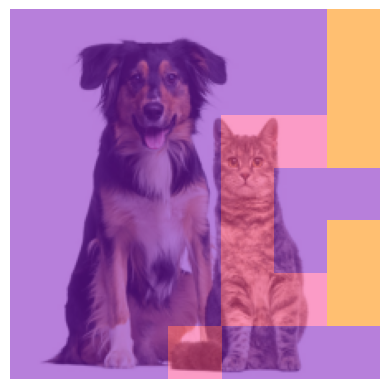

In [30]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.colors as mcolors

colors = np.array(list_of_colors)[1:]
colors = colors.reshape(7,7)

# upscale to 224 x 224
colors = np.repeat(np.repeat(colors, 32, axis=0), 32, axis=1)


# Create a color grid that matches the image size
# For simplicity, fill the grid with a single color based on classification
# Note: This part of the code would need adjustment for real color application
# Create a custom colormap with transparent color for 0, and semi-transparent colors for 1 and 2
# Using RGBA format where the last value is the alpha (transparency)
cmap = mcolors.ListedColormap([
    (0.98, 0.3, 0.6, 0.8),  # Vibrant pink
    (0.5, 0.1, 0.75, 0.8),  # Deep purple
    (1, 0.55, 0.0, 0.8)     # Bright orange
])

# Ensure the overlay array is correctly prepared
# overlay = ... (your overlay logic here)
# Open and display the downloaded image
image = Image.open('cat_dog.jpeg')
image = transform(image)

# Display the image
plt.imshow(image.permute(1,2,0))
# Display the overlay with the custom colormap
plt.imshow(colors, cmap=cmap, alpha=0.7)  # You may adjust or remove the alpha here since colors are already defined with transparency

# Remove axis labels and ticks
plt.axis('off')

# Show the plot
plt.show()

In [31]:
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

# Keywords to identify cat-related entries, prepared as a regex pattern for whole words


def cat_dog_grouped_by_class(image, patch_dictionary, patch_size=32,imagenet_class_to_emoji=IMAGENET_EMOJI):

    cat_pattern = r'\b(' + '|'.join(cat_keywords) + r')\b'
    dog_pattern = r'\b(' + '|'.join(dog_keywords) + r')\b'
    data_array_formatted = np.array([[item[0] for item in list(patch_dictionary.values())[i]] for i in range(50)])

    # Extracting labels for hover text
    hover_text = [[str(i) + " " + item[1] for item in list(patch_dictionary.values())[i]] for i in range(50)]

    if isinstance(image, np.ndarray) and image.shape[-1] == 3:
        # Image is in correct format.
        pass
    elif isinstance(image, torch.Tensor):
        # Convert torch.Tensor to numpy.ndarray if necessary.
        image = image.detach().cpu().numpy().transpose(1, 2, 0)
        if image.max() <= 1.0:
            image *= 255  # Convert from [0, 1] to [0, 255] if needed.
        image = image.astype(np.uint8)

    grid_size_x = image.shape[1] // patch_size
    grid_size_y = image.shape[0] // patch_size

    # Initialize the logit matrix with NaNs for the heatmap.
    color_matrix = np.full((grid_size_y, grid_size_x), np.nan)

    # Create the base figure with the image.
    fig = px.imshow(image)
    fig.update_traces(hoverinfo='none', hovertemplate=None)

    annotations = []
    hover_texts = []
    x_centers = []
    y_centers = []


    for patch_index, patch_data in sorted(patch_dictionary.items()):
        if patch_index == 0:
            continue  # Skip the CLS token.

        # Extract the class index and logit value.
        last_logit_data = patch_data[-1]
        logit_value, class_name, class_index = last_logit_data

        # Calculate the grid position, adjusting for the index starting from 1.
        adjusted_index = patch_index - 1
        row, col = divmod(adjusted_index, grid_size_x)

        # Assign the logit value to the correct position in the matrix for the heatmap.
        # logit_matrix[row, col] = logit_value

        # Determine the emoji for the class index.
        cat_match = re.search(cat_pattern, class_name, re.IGNORECASE)
        dog_match = re.search(dog_pattern, class_name, re.IGNORECASE)

        if cat_match:
          emoji = "🐱"
          color_matrix[row, col] = 0
        elif dog_match:
          emoji = "🐶"
          color_matrix[row, col] = 1
        else:
          emoji = ""
          color_matrix[row, col] = 2

        # emoji = imagenet_class_to_emoji.get(class_index, "❓")

        cmap = mcolors.ListedColormap([
          (0.98, 0.3, 0.6, 0.8),  # Vibrant pink
          (0.5, 0.1, 0.75, 0.8),  # Deep purple
          (1, 0.55, 0.0, 0.8)     # Bright orange
      ])

        # Convert the matplotlib colormap to a Plotly colorscale
        colors = cmap.colors  # Get the list of colors in the colormap
        colorscale = [[i / (len(colors) - 1), f'rgba({c[0]*255}, {c[1]*255}, {c[2]*255}, {c[3]})'] for i, c in enumerate(colors)]

        # Add emoji annotations at the center of each patch.
        annotations.append(go.layout.Annotation(x=col * patch_size + patch_size / 2,
                                                y=row * patch_size + patch_size / 2,
                                                text=emoji,
                                                showarrow=False,
                                                font=dict(size=16)))

        # Prepare hover text information.
        hover_texts.append(f"Patch: {patch_index}<br>Class: {class_name}<br>Logit: {logit_value:.2f}")
        x_centers.append(col * patch_size + patch_size / 2)
        y_centers.append(row * patch_size + patch_size / 2)

    # Overlay the heatmap for logit values with corrected alignment and a colorbar.
    heatmap = go.Heatmap(z=color_matrix, x0=0.5 * patch_size, dx=patch_size, y0=0.5 * patch_size, dy=patch_size, opacity=0.45, colorscale=colorscale, colorbar=dict(title="Logit Values"), hoverinfo="none")
    fig.add_trace(heatmap)

    # Add scatter for hover information.
    fig.add_trace(go.Scatter(x=x_centers, y=y_centers, mode='markers', marker=dict(color='rgba(0,0,0,0)'),
                             hoverinfo='text', text=hover_texts, hoverlabel=dict(bgcolor="white", font_size=12, font_family="Arial")))

    # Update the figure with annotations for emojis.
    fig.update_layout(annotations=annotations)

    # Update layout to hide axes tick labels and show the colorbar.
    fig.update_layout(showlegend=False)
    fig.update_layout(showlegend=False, plot_bgcolor='rgba(0,0,0,0)')
    fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)

    return fig  # Return the figure for displaying.


In [32]:
cat_dog_grouped_by_class(image, patch_dictionary)

## Head attribution

In [33]:
import einops

def residual_stack_to_logit_attn(
    residual_stack,
    cache,
    answer_residual_direction
) -> float:
    scaled_residual_stack = cache.apply_ln_to_stack(
        residual_stack, layer=-1, pos_slice=0
    )
    return einsum(
        "... batch d_model, d_model -> ...",
        scaled_residual_stack,
        answer_residual_direction,
    )

per_head_residual, labels = cache.stack_head_results(
    layer=-1, pos_slice=0, return_labels=True
)


per_head_logit_diffs = residual_stack_to_logit_attn(per_head_residual, cache, cat_answer_residual_direction)


per_head_logit_diffs = einops.rearrange(
    per_head_logit_diffs,
    "(layer head_index) -> layer head_index",
    layer=model.cfg.n_layers,
    head_index=model.cfg.n_heads,
)
px.imshow(
    per_head_logit_diffs.detach().cpu().numpy(),
    labels={"x": "Head", "y": "Layer"},
    title="Logit Difference From Each Head (CLS token)",
)

Tried to stack head results when they weren't cached. Computing head results now


# Attention analysis

We'll look at both attention scores and attention patterns.

In [34]:
def visualize_attention(
    heads,
    local_cache,
    # local_tokens,
    title,
    max_width,
    batch_idx,
    attention_type = 'attn_scores' # or 'attn_patterns'
) -> str:
    # If a single head is given, convert to a list
    if isinstance(heads, int):
        heads = [heads]

    # Create the plotting data
    labels: List[str] = []
    patterns: List[Float[torch.Tensor, "dest_pos src_pos"]] = []


    for head in heads:
        # Set the label
        layer = head // model.cfg.n_heads
        head_index = head % model.cfg.n_heads
        labels.append(f"L{layer}H{head_index}")

        # Get the attention patterns for the head
        # Attention patterns have shape [batch, head_index, query_pos, key_pos]

        patterns.append(local_cache[attention_type, layer][batch_idx, head_index])

    # # Convert the tokens to strings (for the axis labels)
    # str_tokens = model.to_str_tokens(local_tokens)

    # Combine the patterns into a single tensor
    patterns = torch.stack(
        patterns, dim=0
    )
    print(patterns.shape)
    return patterns# Look at those heads [display all heads, modify function if necessary]

### Attention Scores

In [35]:
import importlib

# First, ensure you have imported the module at least once
import vit_prisma.visualization.visualize_attention_js

# Reload the module
importlib.reload(vit_prisma.visualization.visualize_attention_js)

# Now, import the specific function you need
from vit_prisma.visualization.visualize_attention_js import plot_javascript


In [36]:
from vit_prisma.visualization.visualize_attention_js import plot_javascript
from IPython.core.display import display, HTML

top_k = 3
top_positive_logit_attr_heads = torch.topk(
    per_head_logit_diffs.flatten(), k=top_k
).indices

print(top_positive_logit_attr_heads)

batch_idx = 0
patterns = visualize_attention(top_positive_logit_attr_heads, cache, "Attention Scores", 700, batch_idx = batch_idx, attention_type="attn_scores")

html_code = plot_javascript(patterns, [image, image, image], ATTN_SCALING=8)


tensor([136, 137, 143])
torch.Size([3, 50, 50])


FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/lib/python3.10/dist-packages/vit_prisma/visualization/template.html'

### Attention patterns

In [ ]:
import os
template_folder = os.path.dirname(os.path.abspath(__file__))
template_folder

# [Optional] A Brief Attention Head Tour

## All attention heads

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def plot_attn_heads(total_activations, n_heads=12, n_layers=12, img_shape=50, idx=0, figsize=(20, 20),
                    global_min_max=False, global_normalize=False, fourier_transform_local=False, log_transform=False,
                    fourier_transform_global=False, graph_type="imshow_graph", cmap='viridis'):

    # New shape handling: total_activations is now expected to be of shape [n_layers*n_heads, img_shape, img_shape]
    total_data = np.zeros((n_layers*n_heads, img_shape, img_shape))

    # Adjusted processing for flattened layer-heads structure
    if global_min_max or global_normalize or fourier_transform_global:
        for i in range(n_layers*n_heads):
            data = total_activations[i, :, :]
            if log_transform:
                data = np.log10(np.maximum(data, 1e-6))  # log10_stable equivalent
            if fourier_transform_global:
                data = np.abs(np.fft.fftshift(np.fft.fft2(data)))
            total_data[i, :, :] = data

        total_min, total_max = np.min(total_data), np.max(total_data)
        print(f"Total Min: {total_min}, Total Max: {total_max}")

        if global_normalize:
            total_data = -1 + 2 * (total_data - total_min) / (total_max - total_min)

    fig, axes = plt.subplots(n_layers, n_heads, figsize=figsize, squeeze=False)  # Ensure axes is always 2D array
    total_data_dict = {}

    for i in range(n_layers):
        total_data_dict[f"Layer_{i}"] = {}
        for j in range(n_heads):
            # Adjust indexing for the flattened layer-head structure
            linear_idx = i * n_heads + j
            data = total_data[linear_idx, :, :]

            if graph_type == "histogram_graph":
                data = data.flatten()
                axes[i, j].hist(data, bins=100, log=log_transform, cmap=cmap)
            elif graph_type == "imshow_graph":
                if fourier_transform_local:
                    data = np.abs(np.fft.fftshift(np.fft.fft2(data)))
                vmin, vmax = (total_min, total_max) if (global_min_max or global_normalize) else (data.min(), data.max())
                im = axes[i, j].imshow(data, vmin=vmin, vmax=vmax, cmap=cmap)
                axes[i, j].axis('off')
                total_data_dict[f"Layer_{i}"][f"Head_{j}"] = data.tolist()

            axes[i, j].set_title(f"Head {j}", fontsize=12, pad=5) if i == 0 else None
            if j == 0:
                axes[i, j].text(-0.3, 0.5, f"Layer {i}", fontsize=12, rotation=90, ha='center', va='center', transform=axes[i, j].transAxes)

    # Add colorbar for imshow_graph
    if graph_type == "imshow_graph" and (global_min_max or global_normalize):
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_title('Attention', size=12)

    plt.subplots_adjust(wspace=0.2, hspace=0.4)
    plt.suptitle(f'Attention Scores for Image Idx {idx}', fontsize=20, y=0.93)
    plt.show()


In [ ]:
all_attentions = [cache['attn_scores', head_idx].squeeze(0) for head_idx in range(12)]
all_attentions = torch.cat(all_attentions, dim=0)
all_attentions.shape

In [ ]:
plot_attn_heads(all_attentions, global_min_max=True)

## Random cool attention heads

In [ ]:

layer_idx = 0
attn_idx = 3
datapoint_idx = 0

attn_head = all_attentions[2].unsqueeze(0)
print(attn_head.shape)
html_code = plot_javascript(attn_head, image, ATTN_SCALING=8, cls_token=True)
display(HTML(html_code))

# Activation Patching

Please note parts of this section may crash without Colab pro on the high-RAM setting. I've hardcoded the resulting logit difference graphs into the notebook as HTML files. Feel free to only run the code if you have the computational resources.

### Crop out the dog

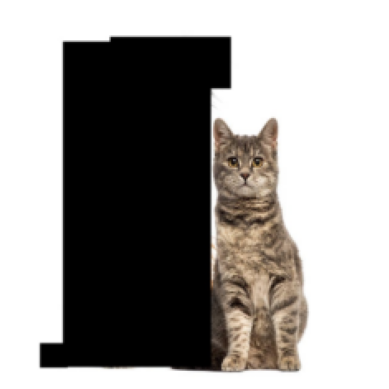

In [37]:
# Let's bring in a corrupted image
# Open and display the downloaded image
corrupted_image = Image.open('crop_dog.jpeg')
corrupted_image = transform(corrupted_image)

plt.figure()
plt.axis('off')
plt.imshow(corrupted_image.permute(1,2,0))


In [40]:

def logits_to_ave_logit_diff(logits, answer_tokens, per_prompt=False):
    # Ensure answer_tokens is a 1D tensor
    if answer_tokens.dim() > 1:
        answer_tokens = answer_tokens.squeeze()  # This squeezes out dimensions of size 1
    # Check again if it's still not 1D (e.g., a 2D tensor that wasn't just a single row/column)
    if answer_tokens.dim() > 1:
        raise ValueError("answer_tokens must be a 1D tensor")

    # Use index_select with the now-1D answer_tokens tensor
    answer_logits = torch.index_select(logits, dim=1, index=answer_tokens)

    # Calculate the difference between the two selected logits
    answer_logit_diff = answer_logits[:, 0] - answer_logits[:, 1]
    return answer_logit_diff


In [41]:
answer_tokens = [[cat_index, dog_index]]
answer_tokens = torch.Tensor(answer_tokens).long()

clean_logits, clean_cache = model.run_with_cache(image.unsqueeze(0))
clean_logit_difference = logits_to_ave_logit_diff(clean_logits, answer_tokens)
print("Logit difference of clean:", clean_logit_difference.item())

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_image.unsqueeze(0))
corrupted_logit_difference = logits_to_ave_logit_diff(corrupted_logits, answer_tokens.squeeze())
print("Logit difference of corrupted:", corrupted_logit_difference.item())


Logit difference of clean: 0.4996565580368042
Logit difference of corrupted: 9.982810020446777


## Residual stream

In [1]:
from functools import partial
import vit_prisma.utils.prisma_utils as prisma_utils
from tqdm import tqdm

# Do activation patching
def patch_residual_component(
        corrupted_residual_component,
        hook,
        pos,
        clean_cache
):
    corrupted_residual_component[:, pos, :] = clean_cache[hook.name][:, pos, :]
    return corrupted_residual_component

def normalize_patched_logit_diff(patched_logit_diff):
    # Subtract corrupted logit diff to measure the improvement, divide by the total improvement from clean to corrupted to normalise
    # 0 means zero change, negative means actively made worse, 1 means totally recovered clean performance, >1 means actively *improved* on clean performance
    return (patched_logit_diff - corrupted_logit_difference) / (
        clean_logit_difference - corrupted_logit_difference
    )

num_tokens=50
layer_num = model.cfg.n_layers
patched_residual_stream = np.empty((layer_num, num_tokens))
for layer in tqdm(range(model.cfg.n_layers)):
    for position in range(num_tokens):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)
        patched_logits = model.run_with_hooks(
            corrupted_image.unsqueeze(0),
            fwd_hooks=[(prisma_utils.get_act_name("resid_pre", layer), hook_fn)],
            # return_type="logits",
        )
        patched_logit_diff = logits_to_ave_logit_diff(patched_logits, answer_tokens.squeeze(0), per_prompt=False)
        logit_diff = normalize_patched_logit_diff(patched_logit_diff)
        patched_residual_stream[layer, position] = logit_diff.item()

NameError: name 'model' is not defined

In [ ]:
import plotly.express as px
import numpy as np

# Assuming patched_mlp_diff is a 2D numpy array with shape (n_layers, n_patches)
# For demonstration, let's create a dummy 2D array if not already defined
# This should be replaced with: patched_mlp_diff.detach().numpy() if you have the tensor
n_layers = model.cfg.n_layers  # Example number of layers
n_patches = model.cfg.n_patches  # Example number of patches

# Create a text label array to display layer and patch numbers
text_labels = np.array([['Layer: {}, Patch: {}'.format(i, j) for j in range(n_patches)] for i in range(n_layers)])

fig = px.imshow(
patched_residual_stream,
labels=dict(x="Patch Number", y="Layer Number", color="Difference"),
    x=np.arange(n_patches),
    y=np.arange(n_layers),
    text_auto=False,
    color_continuous_scale='magma'  # or any other color scale
)

# Update traces to show custom text (layer and patch numbers)
for i in range(len(fig.data)):
    fig.data[i].text = text_labels
    fig.data[i].hovertemplate = 'Layer: %{y}<br>Patch: %{x}<br>Difference: %{z}<extra></extra>'

fig.update_layout(
    title="Normalized Patched Residual Difference per Layer and Patch",
    xaxis_title="Patch Number",
    yaxis_title="Layer Number"
)

fig.update_xaxes(side="top")  # Move the x-axis to the top

# Save the plot as HTML file
file_path = "residual.html"

fig.write_html(file_path)

file_path

fig.show()


In [ ]:
display_grid_on_image(corrupted_image.clone())
# Include the average of the graphs above on the heatmap

## Attention layer

Takes ~10 minutes to run on Colab's high RAM setting. If you're not on the high RAM setting, free to skip running it and just inspect the hardcoded-HTML file resulting from the code.

In [ ]:
from vit_prisma.utils import prisma_utils


patched_attn_diff = torch.zeros(
    model.cfg.n_layers, 50, dtype=torch.float32
)

for layer in tqdm(range(model.cfg.n_layers)):
    for position in range(50):
        hook_fn = partial(patch_residual_component, pos=position, clean_cache=clean_cache)
        patched_attn_logits = model.run_with_hooks(
            corrupted_image.unsqueeze(0),
            fwd_hooks=[(prisma_utils.get_act_name("attn_out", layer), hook_fn)],
        )
        patched_attn_logit_diff = logits_to_ave_logit_diff(
            patched_attn_logits, answer_tokens
        )

        patched_attn_diff[layer, position] = normalize_patched_logit_diff(
            patched_attn_logit_diff
        )

        del patched_attn_logits, patched_attn_logit_diff

 42%|████▏     | 5/12 [00:51<01:12, 10.42s/it]

## MLP layer

## Attention heads